In [73]:
library(xgboost)

In [76]:
source("../src/data/read_dmc.R")

orig_train = read_dmc("../data/train.csv")
orig_items = read_dmc("../data/items.csv")
orig_class = read_dmc("../data/class.csv")

In [117]:
df = merge(orig_train, orig_items, by = "pid")

df = df[order(df$lineID), ]
df$quantity = df$revenue / df$price

In [118]:
label = df$revenue
train_mat = df[!(names(df) %in% c("click", "basket", "order", "revenue"))]

In [17]:
head(train_mat)

,pid,lineID,day,adFlag,availability,competitorPrice,price,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,campaignIndex,rrp
953577,6570,1,1,0,2,14.6,16.89,255,2FOI,50,ML,TRO,0,40,193,NA,18.25
1916348,14922,2,1,1,1,8.57,8.75,18,1COJ0FIK,50,ST,TAB,1,40,66,C,18.81
2109080,16382,3,1,0,1,14.77,16.06,41,22OI7,2X50,ML,STI,0,53,40,NA,18.48
129870,1145,4,1,1,1,6.59,6.55,52,18OZ00IS,60,G,GEL,0,40,25,NA,9.31
528907,3394,5,1,0,1,4.39,4.14,90,20OI0,25X2,ST,KOM,0,53,14,NA,8.13
560194,3661,6,1,0,1,13.66,10.03,90,13OX06,1000,ML,LOE,0,52,127,NA,21.6


## Meeting 4/25

Do competitor prices vary within PIDs?

In [23]:
sort(table(train$pid), decreasing = T)[1:10]


 2655  2491 16641 16144  7403  3853  1426  1247  1037  1567 
53785 14666 12369 11134 10002  8683  8396  7949  7933  7761 

In [35]:
z = aggregate(train$price, list(train$day, train$pid), var)

In [38]:
sum(z$x[!is.na(z$x)])

[1] 2446.428

The above shows there is some variation within days.

In [126]:
train = df[df$day <= 62, ]
test = df[df$day > 62, ]

In [127]:
label_cols = c("click", "basket", "order", "revenue", "quantity")

train_labels = train[label_cols]
train = train[!(names(train) %in% label_cols)]

test_labels = test[label_cols]
test = test[!(names(test) %in% label_cols)]

In [128]:
delete_cols = c("pid", "lineID")
train = train[!(names(train) %in% delete_cols)]
test = test[!(names(test) %in% delete_cols)]

In [129]:
head(train)

,day,adFlag,availability,competitorPrice,price,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,campaignIndex,rrp
953577,1,0,2,14.6,16.89,255,2FOI,50,ML,TRO,0,40,193,NA,18.25
1916348,1,1,1,8.57,8.75,18,1COJ0FIK,50,ST,TAB,1,40,66,C,18.81
2109080,1,0,1,14.77,16.06,41,22OI7,2X50,ML,STI,0,53,40,NA,18.48
129870,1,1,1,6.59,6.55,52,18OZ00IS,60,G,GEL,0,40,25,NA,9.31
528907,1,0,1,4.39,4.14,90,20OI0,25X2,ST,KOM,0,53,14,NA,8.13
560194,1,0,1,13.66,10.03,90,13OX06,1000,ML,LOE,0,52,127,NA,21.6


In [130]:
# group, content, unit, pharmForm, campaignIndex
# Convert categories to numbers
train = lapply(train, function(col) {
   if (!inherits(col, "character"))
       return (col)
    
    unclass(factor(col))
})
train = as.data.frame(train)

In [131]:
train = data.matrix(train)

In [132]:
# Convert categories to numbers
test = lapply(test, function(col) {
   if (!inherits(col, "character"))
       return (col)
    
    unclass(factor(col))
})
test = data.matrix(as.data.frame(test))

In [133]:
#model = xgboost(data = train, label = train_labels$order,
#                max.depth = 2, eta = 1, nthread = 2, nround = 2, objective = "binary:logistic")
model = xgboost(data = as.matrix(train), label = train_labels$order,
                max.depth = 2, eta = 1, nthread = 2, nround = 2, objective = "binary:logistic")


[1]	train-error:0.263378 
[2]	train-error:0.263378 


In [134]:
model

##### xgb.Booster
raw: 1.2 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks, max.depth = 2, eta = 1, nthread = 2, 
    objective = "binary:logistic")
params (as set within xgb.train):
  max_depth = "2", eta = "1", nthread = "2", objective = "binary:logistic", silent = "1"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
  cb.evaluation.log()
  cb.save.model(save_period = save_period, save_name = save_name)
niter: 2
evaluation_log:
 iter train_error
    1    0.263378
    2    0.263378

In [135]:
preds = predict(model, test)

In [136]:
preds01 = ifelse(preds <= 0.3, 0, 1)

In [137]:
prop.table(table(test_labels$order, preds01))

   preds01
             0          1
  0 0.64174959 0.11622339
  1 0.17824106 0.06378596

Fitting a second layer model

In [138]:
is_train2 = (train_labels$order == 1)
train2 = train[is_train2, ]

In [141]:
summary(train_labels$quantity[is_train2])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.371   1.000 306.000 

In [142]:
var(train_labels$quantity[is_train2])

[1] 2.54897

In [210]:
model2_data = as.data.frame(train2)
model2_data[["quantity"]] = train_labels$quantity[is_train2]
model2 = glm(as.integer(quantity) ~ ., data = model2_data, family = quasipoisson)

In [206]:
sum(train_labels$quantity[is_train2] >= 3)

[1] 28090

In [207]:
table(train_labels$quantity[is_train2])


     1      2      3      4      5      6      7      8      9     10     11 
376292  61807  15707   6605   4743   1643    229    369     70   1319     28 
    12     13     14     15     16     17     18     19     20     21     22 
    97      9     14    124     14      9     12      3    253      4     12 
    23     24     25     26     27     28     30     31     35     36     40 
     1      6     19      2      1      2     43      1      5      4     23 
    45     50     55     60     65     80     84     90     99    100    115 
     1     31      1      2      1      1      1      1      2     21      1 
   200    300    306 
     1      1      1 

Check prices of extremely high quantity lines

In [214]:
summary(predict(model2, type = "response"))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6772  1.1520  1.2110  1.2320  1.3130  1.7580 

In [212]:
model2


Call:  glm(formula = as.integer(quantity) ~ ., family = quasipoisson, 
    data = model2_data)

Coefficients:
    (Intercept)              day           adFlag     availability  
     -3.622e-01        4.786e-04        2.476e-02       -2.072e-02  
competitorPrice            price     manufacturer            group  
     -1.052e-02        3.476e-03       -8.492e-05        1.803e-04  
        content             unit        pharmForm   genericProduct  
     -1.042e-04       -2.366e-02       -2.209e-04        4.978e-02  
     salesIndex         category    campaignIndex              rrp  
      1.226e-02       -7.939e-05        1.349e-01       -9.389e-04  

Degrees of Freedom: 80722 Total (i.e. Null);  80707 Residual
  (388813 observations deleted due to missingness)
Null Deviance:	    23050 
Residual Deviance: 21500 	AIC: NA

In [116]:
# Fit model on train2


In [114]:
# Predict with 2nd model on this
is_test2 = (preds01 == 1)
test2 = test[is_test2, ]

In [200]:
preds_qty = predict.glm(model2, na.omit(as.data.frame(test2)), type = "response")

In [ ]:
colSums(is.na())

In [198]:
summary(preds_qty)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.7135  1.1730  1.2240  1.2050  1.2670  1.6190 

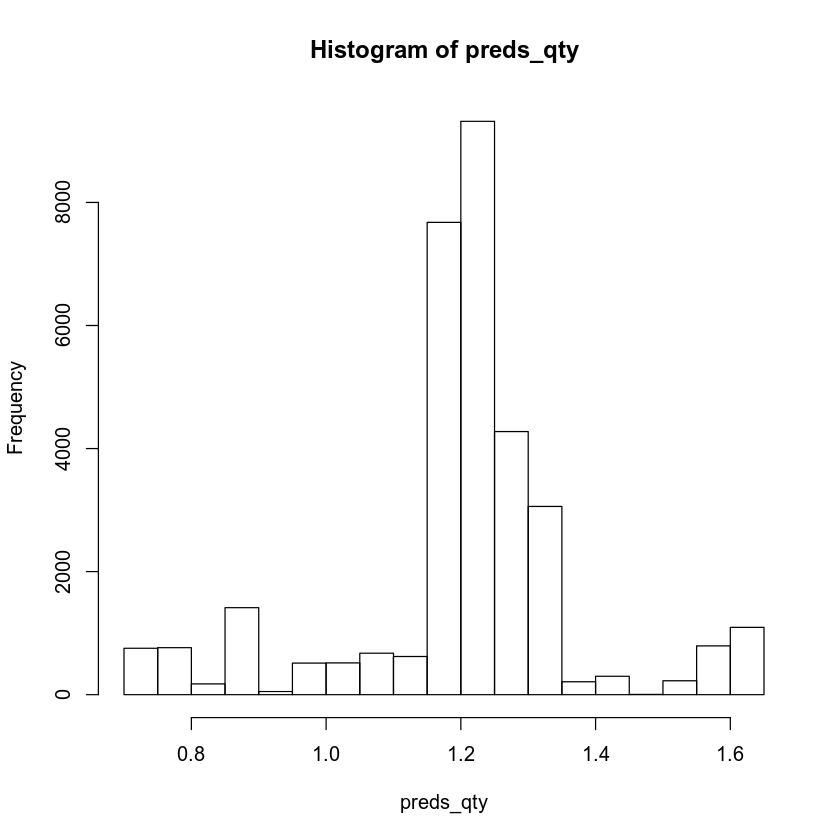

In [199]:
hist(preds_qty)

In [178]:
?predict.glm